In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
from PIL import Image 
from glob import glob

from sklearn.model_selection import train_test_split 
from sklearn import metrics

import cv2 
import gc 
import os

import tensorflow as tf 
from tensorflow import keras 
from keras import layers

import warnings 
warnings.filterwarnings('ignore')

from zipfile import ZipFile

data_path = 'dataset.zip'

with ZipFile(data_path, 'r') as zip:
    zip.extractall() 
    print('The data set has been extracted.')

In [2]:
path = 'lung_colon_image_set/lung_image_sets' 
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

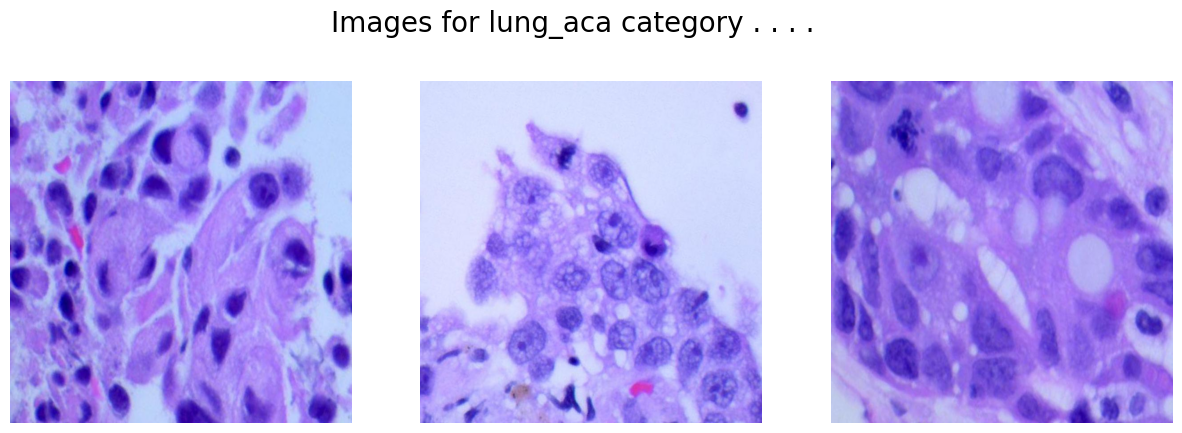

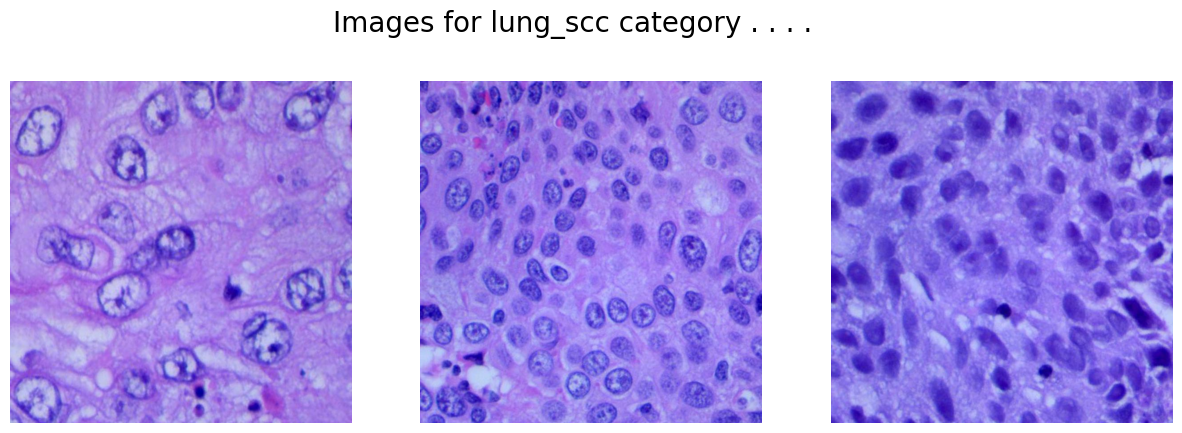

In [3]:
path = 'lung_colon_image_set/lung_image_sets'

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
    fig, ax = plt.subplots (1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [4]:
IMG_SIZE = 256

SPLIT = 0.2

EPOCHS = 10

BATCH_SIZE=64

In [5]:
X=[]

Y=[]

for i, cat in enumerate (classes):
    images=glob(f'{path}/{cat}/*.jpeg')
    for image in images:
        img = cv2.imread(image)
        
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE))) 
        Y.append(i)

X= np.asarray(X)

one_hot_encoded_Y = pd.get_dummies(Y).values
one_hot_encoded_Y

array([[ True, False, False],
       [ True, False, False],
       [ True, False, False],
       ...,
       [False, False,  True],
       [False, False,  True],
       [False, False,  True]])

In [6]:

X_train,X_val,Y_train,Y_val = train_test_split(X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)

print(X_train.shape,X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [7]:
model=keras.models.Sequential([ 
        layers.Conv2D(filters=32,
                    kernel_size=(5, 5),activation='relu',
                    input_shape=(IMG_SIZE,IMG_SIZE,3), padding='same'),
        layers. MaxPooling2D(2, 2),
        
        layers.Conv2D(filters=64,
                      kernel_size=(3, 3), activation='relu',padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(filters=128,
                     kernel_size=(3, 3), activation='relu', padding='same'), 
        
        layers.MaxPooling2D(2, 2),
        
        layers.Flatten(),
        layers. Dense (256, activation='relu'),
        layers. BatchNormalization(), 
        layers. Dense (128, activation='relu'), 
        layers. Dropout(0.3), 
        layers. BatchNormalization(), 
        layers. Dense(3, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,684,291 (128.50 MB)

 Trainable params: 33,683,523 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

In [9]:
keras.utils.plot_model(model,show_shapes = True,show_dtype =True,
                       show_layer_activations=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [10]:
model.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics =['accuracy'])

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto 90% \
                so, stopping further training.')
            self.model.stop_training = True

es=EarlyStopping(patience=3,
                 monitor='val_accuracy',
                 restore_best_weights=True)

lr=ReduceLROnPlateau(monitor='val_loss',
                      patience=2,factor=0.5,
                      verbose=1)

In [12]:
from sklearn.preprocessing import OneHotEncoder
import scipy.sparse

# One-hot encode your training labels
encoder = OneHotEncoder()
Y_train_encoded = encoder.fit_transform(Y_train.reshape(-1, 1))



In [13]:
import sklearn
print(sklearn.__version__)


1.4.2


In [14]:
history=model.fit(X_train, Y_train,
                  validation_data = (X_val, Y_val),
                  batch_size = BATCH_SIZE,
                  epochs = EPOCHS,
                  verbose = 1,
                  callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 654s 3s/step - accuracy: 0.7926 - loss: 0.4946 - val_accuracy: 0.6270 - val_loss: 5.7919 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 605s 3s/step - accuracy: 0.9042 - loss: 0.2444 - val_accuracy: 0.5840 - val_loss: 3.7415 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10554s 56s/step - accuracy: 0.9052 - loss: 0.2437 - val_accuracy: 0.6687 - val_loss: 6.2087 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9314 - loss: 0.1732
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.9314 - loss: 0.1732 - val_accuracy: 0.3453 - val_loss: 13.4473 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.9525 - loss: 0.1272 - val_accuracy: 0.5243 - val_loss: 6.2229 - learning_rate: 5.0000e-04
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - accuracy: 0.9714 - los

In [15]:
model.save("model_new.h5")

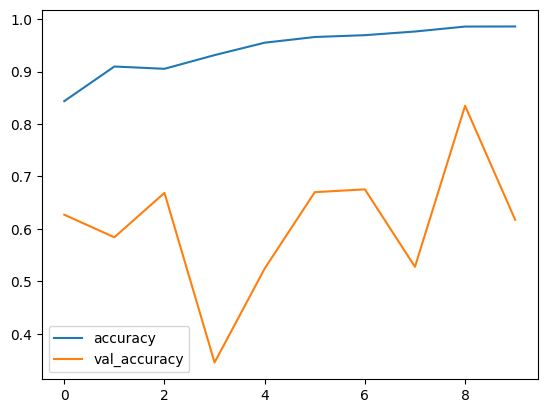

In [16]:
history_df = pd.DataFrame(history.history)

history_df.loc[:,['loss', 'val_loss']].plot()

history_df.loc[:,['accuracy', 'val_accuracy']].plot()
plt.show()

In [17]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val,axis=1)
Y_pred =np.argmax(Y_pred,axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 357ms/step


In [18]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[ 586,    0,  401],
       [  74,  899,    4],
       [  17,    0, 1019]], dtype=int64)

In [19]:
print(metrics.classification_report (Y_val, Y_pred, target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.87      0.59      0.70       987
      lung_n       1.00      0.92      0.96       977
    lung_scc       0.72      0.98      0.83      1036

    accuracy                           0.83      3000
   macro avg       0.86      0.83      0.83      3000
weighted avg       0.86      0.83      0.83      3000



In [23]:
#Now, you can load the model for testing
loaded_model=tf.keras.models.load_model('model_new.h5')
#Use the Loaded model for predictions on new images
#new_image_path= "lungaca161.jpeg"
#new_image_path= "C:\\final_project_LCP\\testing images\\lungscc30.jpeg"
#new_image_path='C:\\final_project_LCP\\testing images\\lungn29.jpeg'
new_image_path= 'C:\\final_project_LCP\\testing images\\lungscc44.jpeg'
#new_image_path="C:\\final_project_LCP\\lung_colon_image_set\\lung_image_sets\\lung_n\\lungn1.jpeg"
new_image=tf.keras.preprocessing.image.load_img(new_image_path, target_size=(256, 256,3))
new_image=tf.keras.preprocessing.image.img_to_array(new_image) 
new_image=tf.expand_dims(new_image, axis=0)
result=loaded_model.predict(new_image)
print(result[0][1])
if result[0][1] >= 1:
    prediction='Cancerous'
else:
    prediction='Non-Cancerous'

print(f"The prediction for the new image is: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1.0
The prediction for the new image is: Cancerous
